# Twitter Climate Change Sentiment Analysis

- Author: Roelle Kim
- Date: 2022-04-05


# Used Dataset

"Twitter Climate Change Sentiment" at https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset.


# Objective

The goal for the model is to distinguish tweets about climate change into one of the three labels:

- 1: pro - support the belief that climate change is caused by the man-kinds.
- 0: neutral
- -1: anti - refuse the belief that climate change is caused by the man-kinds


# EDA


## Load Packages and Data

Before analyzing data, we need to import required packages and the dataset.


In [4]:
!pip install pydataset

In [5]:
# import packages
import pandas as pd
import numpy as np
from os import makedirs
from os import path
import math
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from pydataset import data
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

import pickle
import json

In [6]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "twitter_sentiment_data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "edqian/twitter-climate-change-sentiment-dataset",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

# Filter out the 'news' class (2) so we only keep sentiments -1, 0, 1
df = df[df["sentiment"] != 2].copy()
df.reset_index(drop=True, inplace=True)
print("Kept sentiments:", sorted(df["sentiment"].unique()))

/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_42889/4264311036.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Kept sentiments: [-1, 0, 1]


In [7]:
# set up label dataframe for future refrences

label = [-1, 0, 1]
labelN = ["Anti", "Neutral", "Pro"]
labelDesc = [
    "the tweet does not believe in man-made climate change",
    "the tweet neither supports nor refutes the belief of man-made climate change",
    "the tweet supports the belief of man-made climate change",
]

labelDf = pd.DataFrame(
    list(zip(label, labelN, labelDesc)), columns=["label", "name", "description"]
)

## Data Dictionary


In [8]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the p...,792927353886371840
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...",793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...,793124635873275904
4,0,Unamshow awache kujinga na iko global warming https://t.co/mhIflU7M1X,793125429418815489


The data has a very simple structure with only 2 features. Each row is associated with a unique tweetid, and it shows a tweet pertaining to man-made climate change. The message column shows the content of the tweet and the sentiment column shows the sentiment label that was determined by 3 reviewers.


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34667 entries, 0 to 34666
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  34667 non-null  int64 
 1   message    34667 non-null  object
 2   tweetid    34667 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 812.6+ KB


There are no null counts. Note: After filtering out class '2' (news), the total number of entries is reduced accordingly.


## Distribution of Sentiments


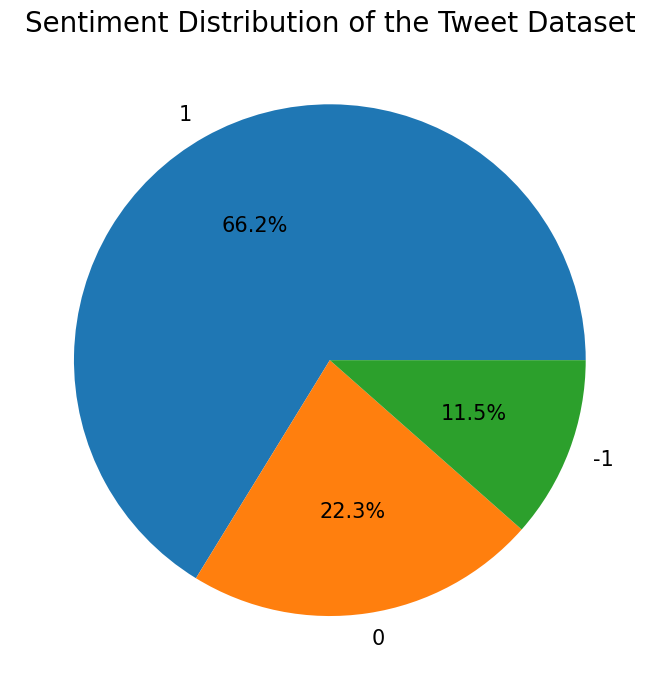

In [10]:
plt.figure(figsize=(7, 7))
plt.pie(
    df.sentiment.value_counts().values,
    labels=df.sentiment.value_counts().index,
    autopct="%2.1f%%",
    textprops={"fontsize": 15},
)
plt.title("Sentiment Distribution of the Tweet Dataset", fontsize=20)
plt.tight_layout()
plt.show()

The pie chart shows the distribution of the data across three classes only: -1 (anti), 0 (neutral), and 1 (pro). Class '2' (news) has been removed from this analysis.


In [11]:
df.sentiment.value_counts()

sentiment
 1    22962
 0     7715
-1     3990
Name: count, dtype: int64

These are the exact numbers of each sentiment label.


# Data Preparation for Sentiment Analysis

Tweet texts will be transformed and vectorized to be fed into models.


In [12]:
# separate the messages column for transformation.
dfTweets = df["message"]

## Tokenization

All the tweets are first split into arrays of words.


In [13]:
def createTokenizedArray(sentences):
    """
    Create lower case array of words with no punctuation.
    :param sentences: array or series of texts
    :return: lower case array of words with no punctuation.
    """
    # Initialize tokenizer and empty array to store modified sentences.
    tokenizer = RegexpTokenizer(r"\w+")
    tokenizedArray = []
    for i in range(0, len(sentences)):
        # Convert sentence to lower case.
        sentence = sentences[i].lower()

        # Split sentence into array of words with no punctuation.
        words = tokenizer.tokenize(sentence)

        # Append word array to list.
        tokenizedArray.append(words)

    # print(tokenizedArray)
    return tokenizedArray  # send modified contents back to calling function.

In [14]:
tokenizedLi = createTokenizedArray(dfTweets)

pd.Series(tokenizedLi[:5])

0    [tiniebeany, climate, change, is, an, interesting, hustle, as, it, was, global, warmin...
1    [rt, natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the,...
2    [fabulous, leonardo, dicaprio, s, film, on, climate, change, is, brilliant, do, watch,...
3    [rt, mick_fanning, just, watched, this, amazing, documentary, by, leonardodicaprio, on...
4              [unamshow, awache, kujinga, na, iko, global, warming, https, t, co, mhiflu7m1x]
dtype: object

Each array contains words of individual tweet.


## Stop Word Removal

Stop words are the words that do not add any significant values to the query search, such as "the", "a", and "an". They are safe to be removed from the tokenized list.


In [15]:
# To get stop words.
nltk.download("stopwords")


def removeStopWords(tokenList):
    """
    Create array of words with no punctuation or stop words.
    :param tokenList: tokenized list
    :return: array of words with no punctuation or stop words.
    """
    stopWords = set(stopwords.words("english"))
    shorterSentences = []  # Declare empty array of sentences.

    for sentence in tokenList:
        shorterSentence = []  # Declare empty array of words in single sentence.
        for word in sentence:
            if word not in stopWords:
                # Remove leading and trailing spaces.
                word = word.strip()

                # Ignore single character words and digits.
                if len(word) > 1 and word.isdigit() == False:
                    # Add remaining words to list.
                    shorterSentence.append(word)
        shorterSentences.append(shorterSentence)
    return shorterSentences

[nltk_data] Downloading package stopwords to /Users/nafis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
tokenizedNoStopLi = removeStopWords(tokenizedLi)

print(f"Sample sentence BEFORE removing stop words:\n{tokenizedLi[0]}")
print(f"\n\nSample sentence AFTER removing stop words:\n{tokenizedNoStopLi[0]}")

Sample sentence BEFORE removing stop words:
['tiniebeany', 'climate', 'change', 'is', 'an', 'interesting', 'hustle', 'as', 'it', 'was', 'global', 'warming', 'but', 'the', 'planet', 'stopped', 'warming', 'for', '15', 'yes', 'while', 'the', 'suv', 'boom']


Sample sentence AFTER removing stop words:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']


You can see the second set of the array now no longer contains some insignificant words such as "is", "an", "as" and "it".


## Stemming

English words are often time variations of a root word. Stemming rebuilds sentences by removing suffixes from words. It potentially improves the sentiment algorithm by accepting different words as one word as long as they were originated from the same stem.


In [17]:
def stemWords(sentenceArrays):
    """
    Removes suffixes and rebuilds the sentences.
    :param sentenceArrays: stentences list
    :return: array of sentences without suffixes
    """
    ps = PorterStemmer()
    stemmedSentences = []
    for sentenceArray in sentenceArrays:
        stemmedArray = []  # Declare empty array of words.
        for word in sentenceArray:
            stemmedArray.append(ps.stem(word))  # Add stemmed word.

        # Convert array back to sentence of stemmed words.
        delimeter = " "
        sentence = delimeter.join(stemmedArray)

        # Append stemmed sentence to list of sentences.
        stemmedSentences.append(sentence)
    return stemmedSentences

In [18]:
stemmedLi = stemWords(tokenizedNoStopLi)

print(f"Sample sentence BEFORE stemming:\n{tokenizedNoStopLi[0]}")
print(f"\nSample sentence AFTER stemming:\n{stemmedLi[0]}")

Sample sentence BEFORE stemming:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']

Sample sentence AFTER stemming:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom


You can see the sentence after stemming has lost some suffixes. "Change" became "chang", "interesting" became "interest" and "warming" became "warm". The array of words has also been converted back to one full sentence.


## Vectorization

Now the stemmed sentences will be vectorized. It essentially transforms all the existing words into numbers so they can be fed to various big data algorithms.


In [19]:
def vectorizeList(stemmedList, ngramRangeStart, ngramRangeEnd):
    """
    Creates a matrix of word vectors.
    :param stemmedList: stemmed sentence list
    :return: matrix of word vectors and vocabulary dictionary
    """
    cv = CountVectorizer(binary=True, ngram_range=(ngramRangeStart, ngramRangeEnd))
    cv.fit(stemmedList)
    X = cv.transform(stemmedList)

    return X, cv.vocabulary_

In [20]:
vectorizedTweets, vectorDictionary = vectorizeList(stemmedLi, 1, 1)

Let's look into 2 different sample sentences to understand better what vectorization does


In [21]:
print(f"Sample sentence #1:\n{stemmedLi[0]}")
print(f"Sample sentence #2:\n{stemmedLi[1]}")

Sample sentence #1:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom
Sample sentence #2:
rt natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang http co lkdehj3tnn httã


Notice these 2 sentences have a couple of words in common - "climat", "chang"


In [22]:
print(f"\n#1 after vectorization:\n{vectorizedTweets[0]}")
print(f"#2 after vectorization:\n{vectorizedTweets[1]}")


#1 after vectorization:
  (0, 8170)	1
  (0, 10062)	1
  (0, 10801)	1
  (0, 19704)	1
  (0, 22345)	1
  (0, 23653)	1
  (0, 36745)	1
  (0, 44393)	1
  (0, 44948)	1
  (0, 46697)	1
  (0, 50288)	1
  (0, 52533)	1
#2 after vectorization:
  (0, 7109)	1
  (0, 10062)	1
  (0, 10801)	1
  (0, 11188)	1
  (0, 22189)	1
  (0, 22197)	1
  (0, 28183)	1
  (0, 28688)	1
  (0, 32626)	1
  (0, 40094)	1
  (0, 40752)	1
  (0, 45292)	1
  (0, 47234)	1
  (0, 50354)	1
  (0, 51349)	1


The prints above show the results of 2 sample sentences after being ve. Each vector signifies a unique word in all tweets. For example, we already know they have 2 words in common; therefore, we can see 2 sets of vectors appearing in both sentences - **(0, 12943)** and **(0, 13774)** - which are representations of "climat" and "chang" respectively.


In [23]:
vectorizedTweets.shape

(34667, 54331)

Based on the column size of our vectorized data, we can see there were 67195 unique words (no stop words, stemmed) in 43943 tweets in the dataset.


## Bi-Grams

Using N-Grams, we can group N numbers of words together and analyze their frequencies for specific sentiment rating.


In [24]:
def generateWordList(wordDf, sentimentScore, n_gram_size):
    resultDf = wordDf[(wordDf["sentiment"] == sentimentScore)]

    sentences = [sentence.split() for sentence in resultDf["transformedTweets"]]
    wordArray = []
    for i in range(0, len(sentences)):
        wordArray += sentences[i]

    counterList = Counter(ngrams(wordArray, n_gram_size)).most_common(80)

    counterDf = pd.DataFrame()

    delimiter = " "
    print(f"\n***N-Gram (Sentiment: {sentimentScore})")
    for i in range(0, len(counterList)):
        counterDict = {
            "N-Gram": delimiter.join(counterList[i][0]),
            "Occurrences": counterList[i][1],
        }
        # convert dict to series before concating to the dataframe.
        counterDict = pd.DataFrame(counterDict, index=[0])
        counterDf = pd.concat([counterDf, counterDict], ignore_index=True)

    return counterDf

In [25]:
# N-Gram variables
SIZE = 2
# add transformedTweets column to the original dataset with the stemmed data.
df["transformedTweets"] = stemmedLi
dfSub = df[["sentiment", "transformedTweets"]]

We'll look in to top 20 bi-grams for each sentiment label.


### Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets (-1)



***N-Gram (Sentiment: -1)
                N-Gram  Occurrences
0         climat chang         2211
1              http co         1873
2          global warm         1855
3             man made          174
4           chang http          150
5     rt stevesgoddard          118
6            warm http          114
7              al gore          103
8              http rt           91
9   rt realdonaldtrump           87
10         made climat           86
11         made global           73
12             warm rt           72
13            chang rt           66
14          chang real           65
15         warm climat           61
16           warm hoax           60
17       believ climat           54
18          chang hoax           53
19         caus global           48


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_42889/2879157074.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

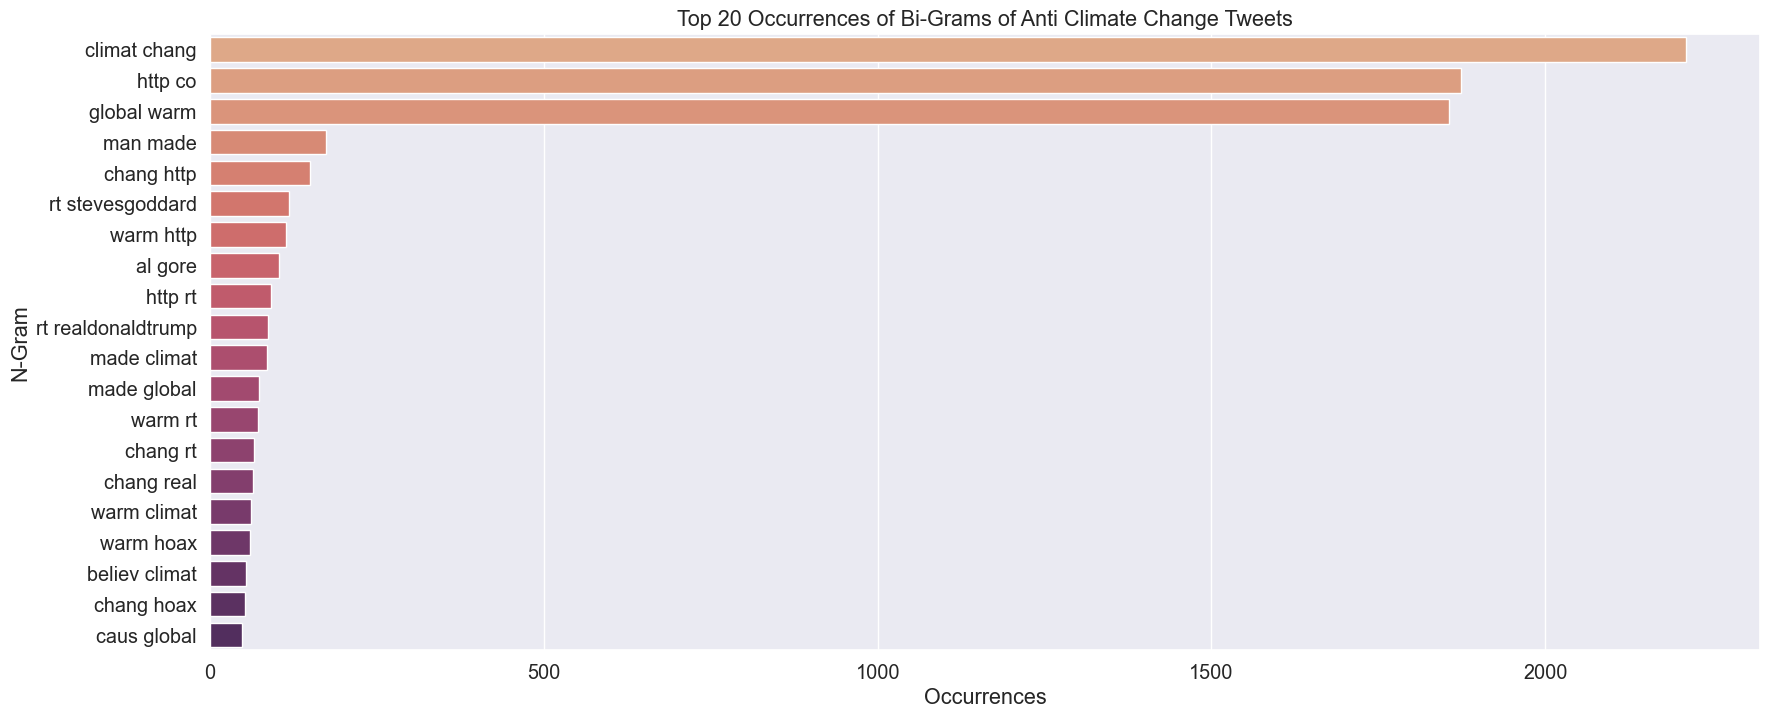

In [26]:
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")

"climat change", "http co" and "global warm" have appeared the most time in the tweets that are refuting climate change is caused by humans. "http co" seems like a link to another website.


### Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets (0)



***N-Gram (Sentiment: 0)
           N-Gram  Occurrences
0    climat chang         4491
1         http co         3271
2     global warm         3109
3      chang http          447
4       warm http          289
5         warm rt          236
6        chang rt          218
7     caus global          137
8       warm real          121
9         http rt          109
10  believ climat          107
11    talk climat           99
12          ðÿ ðÿ           88
13   think global           82
14   club penguin           82
15     chang real           81
16  believ global           75
17    caus climat           70
18   penguin shut           68
19     chang hoax           63


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_42889/2155537556.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

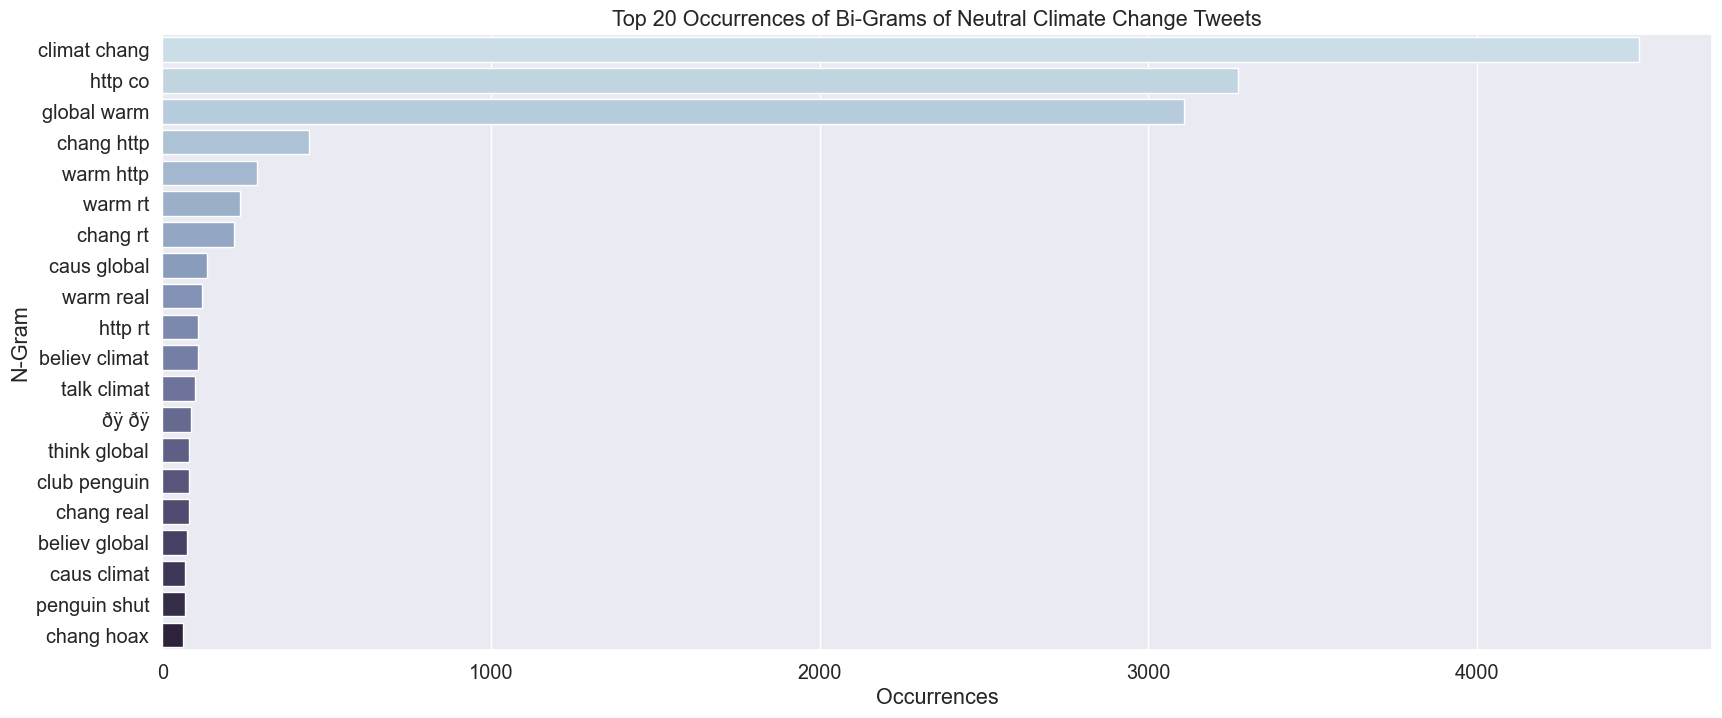

In [27]:
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(
    x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25"
)

Neutral tweets also have very similar patterns to the anti tweets. "climat chang", "http co" and "global warm" are the top 3 followed by "chang http", "warm http", "warm rt" and "chang rt". "rt" is short for "re-tweet".
The only difference may be notable here is that "man made" was not mentioned as the top 20 occurrences in the neutral tweets.


### Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets (1)



***N-Gram (Sentiment: 1)

/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_42889/3802794499.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



                   N-Gram  Occurrences
0            climat chang        19124
1                 http co        12378
2             global warm         3851
3              chang http         2799
4           believ climat         1427
5            fight climat          836
6                 http rt          788
7            chang denier          711
8              chang real          679
9                  go die          540
10               think go          514
11         husband believ          512
12            die husband          510
13     rt stephenschlegel          507
14  stephenschlegel think          507
15             co sjofonã          506
16              warm http          494
17               chang rt          477
18            deni climat          448
19             sjofonã rt          435


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

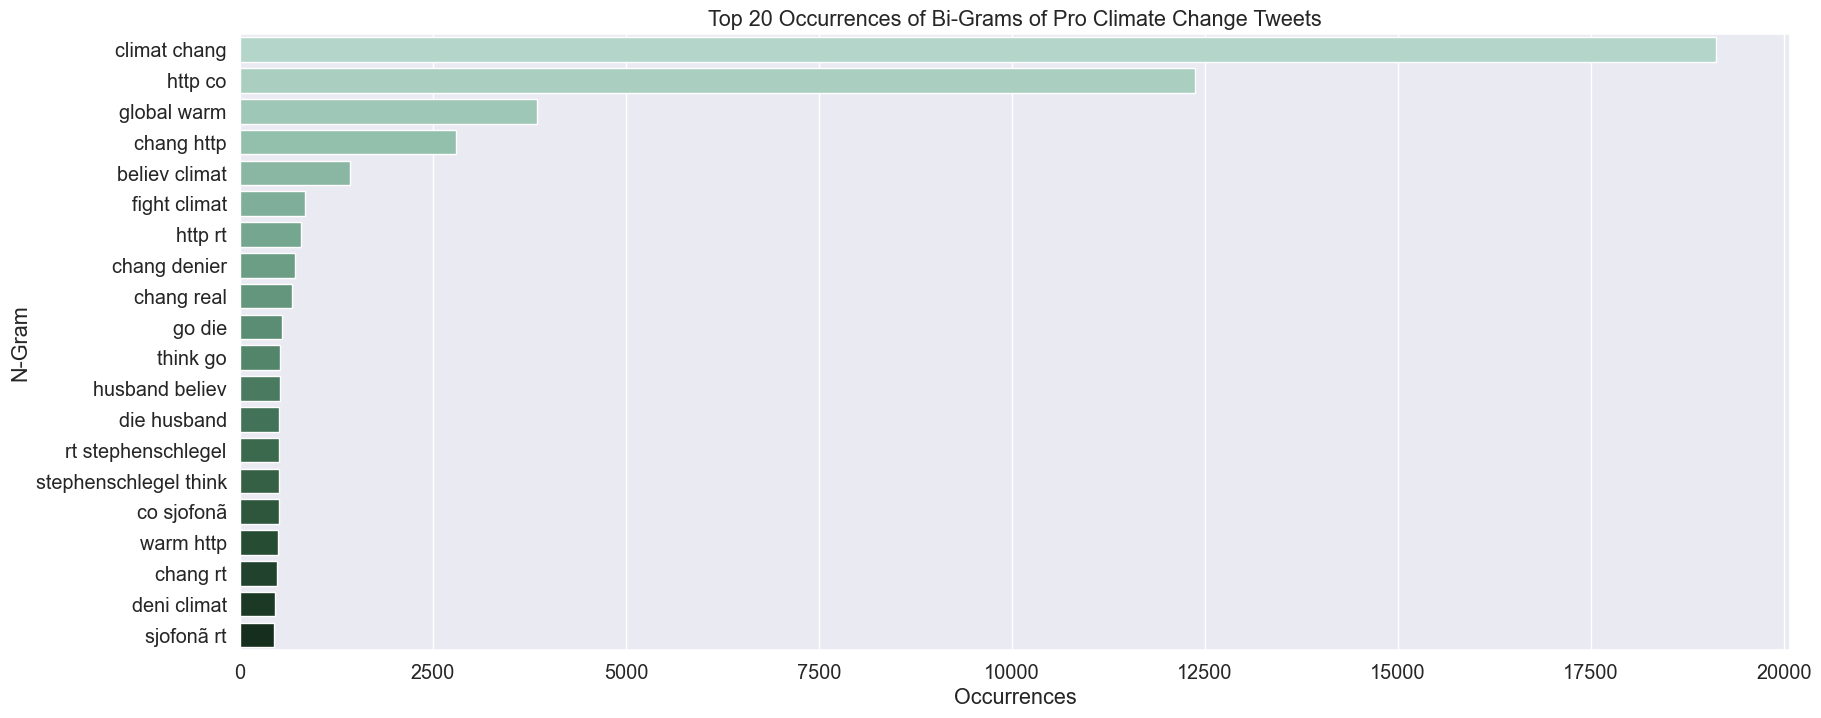

In [28]:
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(
    x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.1,l=0.8"
)

Again, the top 3 bi-grams are "climat chang", "http co" and "global warm" for pro climate change tweets. A considerable size of tweets are containing "believ climat" and "fight climat". Perhaps people were explicitly expressing that they are "believing in climate change" or "fighting for the climate change".


### (Removed) Top 20 Occurrences of Bi-Grams of Factual Climate Change Tweets (2)

Note: Class '2' (news) was removed from the dataset for this run.


In [29]:
# Skipping bi-gram analysis for class '2' since it was removed
if 2 in dfSub["sentiment"].unique():
    counterDfNews = generateWordList(dfSub, 2, SIZE)
    counterDfNewsTop = counterDfNews.head(20)
    print(counterDfNewsTop)

    sns.set(font_scale=1.3)
    plt.figure(figsize=(20, 8))
    plt.title("Top 20 Occurrences of Bi-Grams of News Climate Change Tweets")
    sns.set_style("darkgrid")
    sns.barplot(
        x="Occurrences", y="N-Gram", data=counterDfNewsTop, palette="ch:2.8, r=.1"
    )
else:
    print("Class '2' (news) removed; skipping bi-gram analysis for sentiment 2.")

Class '2' (news) removed; skipping bi-gram analysis for sentiment 2.


The most noticeable thing about the bi-grams is that "http co", "climate chang" and related terms are common across classes. We removed the 'news' class (2), so plots and counts focus on -1, 0, 1 only.


## Tri-Grams

Let's try tri-grams and see if it finds more meaningful combinations of words than bi-grams.


In [30]:
SIZE = 3

## Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets (-1)



***N-Gram (Sentiment: -1)
                 N-Gram  Occurrences
0     climat chang http          146
1         chang http co          138
2      global warm http          112
3          warm http co          105
4     made climat chang           82
5       man made climat           78
6        global warm rt           71
7      made global warm           71
8       man made global           67
9     climat chang real           65
10      climat chang rt           61
11     global warm hoax           60
12   global warm climat           59
13    climat chang hoax           52
14  believ climat chang           52
15    warm climat chang           50
16     global warm data           45
17    caus climat chang           44
18     caus global warm           44
19    global warm creat           43


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_42889/2990623308.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

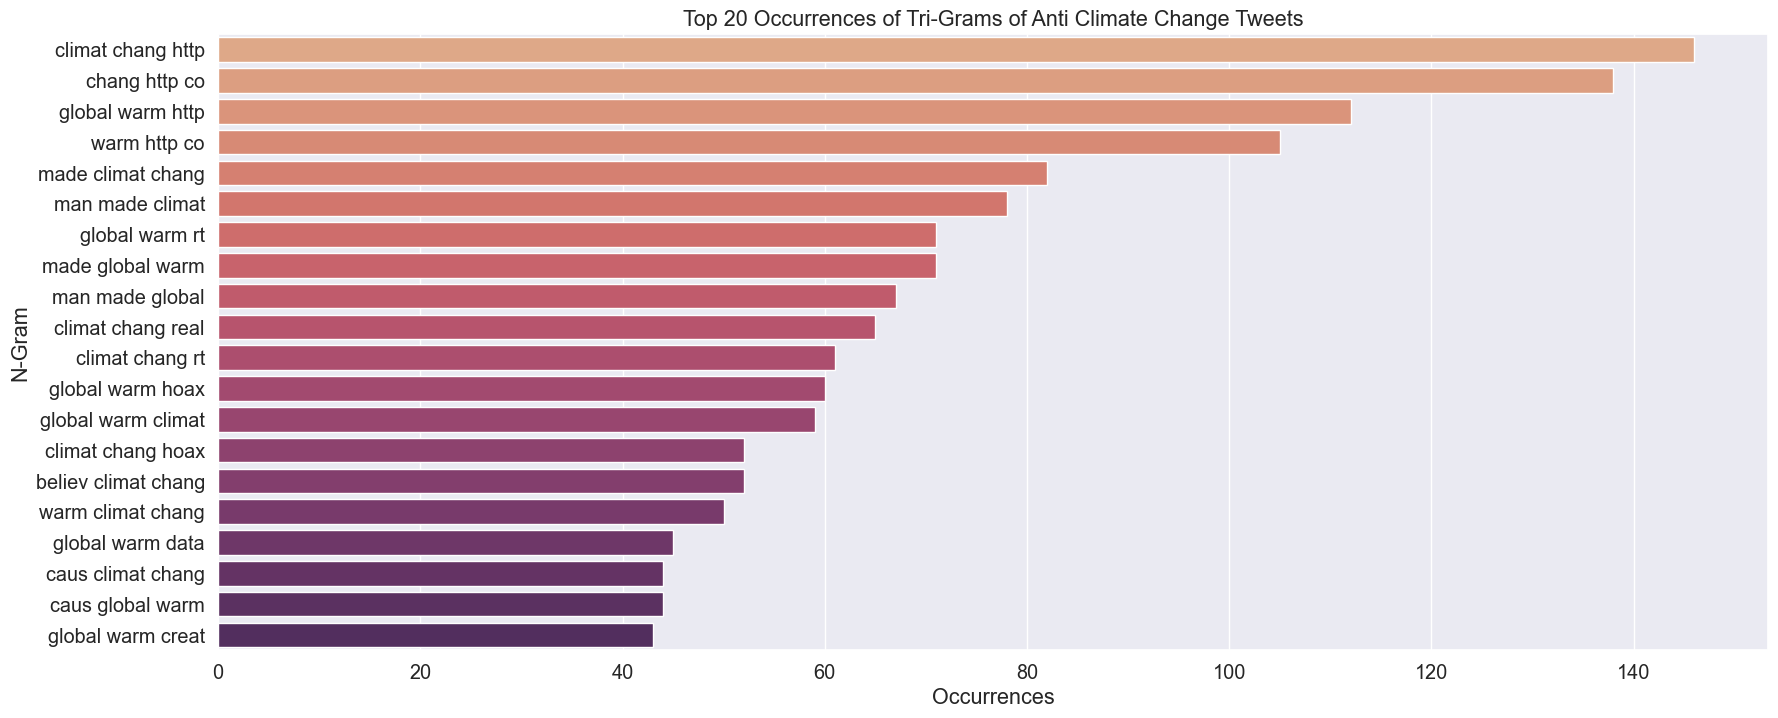

In [31]:
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")

### Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets (0)



***N-Gram (Sentiment: 0)
                 N-Gram  Occurrences
0     climat chang http          444
1         chang http co          424
2      global warm http          289
3          warm http co          280
4        global warm rt          235
5       climat chang rt          214
6      caus global warm          137
7      global warm real          121
8   believ climat chang          106
9     talk climat chang           96
10    think global warm           81
11    climat chang real           81
12   believ global warm           74
13    caus climat chang           69
14    club penguin shut           68
15    climat chang hoax           63
16   think climat chang           58
17     stop global warm           57
18   fight climat chang           56
19     say climat chang           52


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_42889/2904435185.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

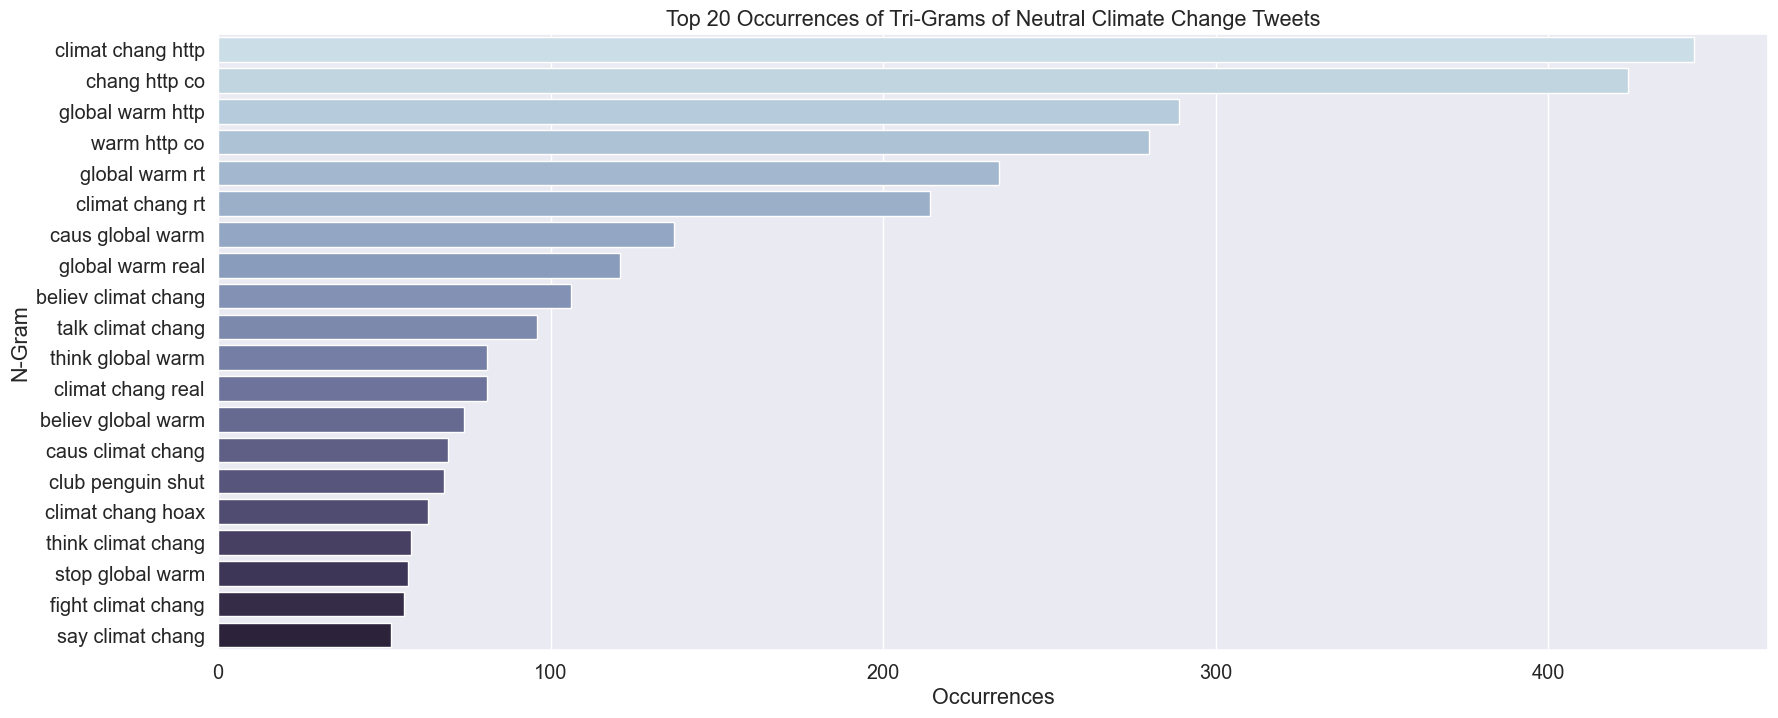

In [32]:
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(
    x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25"
)

### Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets (1)



***N-Gram (Sentiment: 1)
                      N-Gram  Occurrences
0          climat chang http         2787
1              chang http co         2635
2        believ climat chang         1422
3         fight climat chang          822
4        climat chang denier          711
5          climat chang real          679
6      husband believ climat          512
7               think go die          510
8             go die husband          510
9         die husband believ          510
10  rt stephenschlegel think          507
11  stephenschlegel think go          507
12           http co sjofonã          506
13          global warm http          480
14              warm http co          470
15           climat chang rt          465
16             co sjofonã rt          435
17         deni climat chang          428
18        tackl climat chang          385
19       combat climat chang          366


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_42889/4132814696.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.2,l=.6")


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

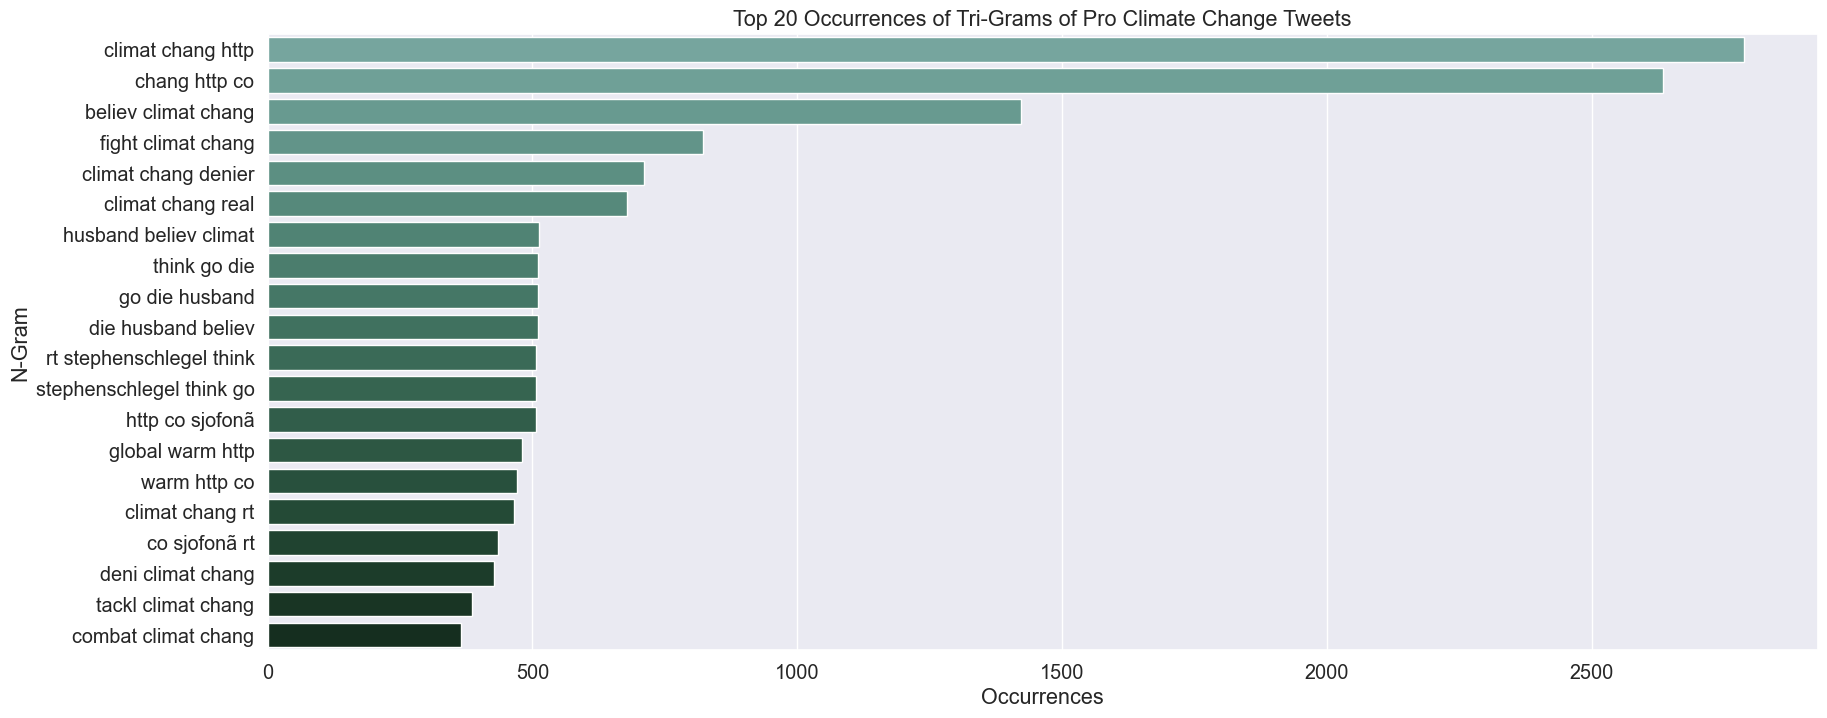

In [33]:
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.2,l=.6")

### (Removed) Top 20 Occurrences of Tri-Grams of Factual Climate Change Tweets (2)

Note: Class '2' (news) was removed from the dataset for this run.


In [34]:
# Skipping tri-gram analysis for class '2' since it was removed
if 2 in dfSub["sentiment"].unique():
    counterDfNews = generateWordList(dfSub, 2, SIZE)
    counterDfNewsTop = counterDfNews.head(20)
    print(counterDfNewsTop)

    sns.set(font_scale=1.3)
    plt.figure(figsize=(20, 8))
    plt.title("Top 20 Occurrences of Tri-Grams of News Climate Change Tweets")
    sns.set_style("darkgrid")
    sns.barplot(
        x="Occurrences", y="N-Gram", data=counterDfNewsTop, palette="light:#D7AF60"
    )
else:
    print("Class '2' (news) removed; skipping tri-gram analysis for sentiment 2.")

Class '2' (news) removed; skipping tri-gram analysis for sentiment 2.


Overall, it seems like tri-grams grab more accurate actions or emotions associated with climate change or global warming.


# Model Development

Various models will be built to predict the sentiment of tweets pertaining to climate change.


In [35]:
def evaluateModel(model, X_test, y_test, title):
    """
    print out classification scores
    :param model: used model
    :param X_test:
    :param y_test:
    :param title: title of the model
    """
    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average="weighted")
    precision = metrics.precision_score(y_test, predictions, average="weighted")
    f1 = metrics.f1_score(y_test, predictions, average="weighted")

    clsScoreDict = {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
    }

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))
    print("\n\n")

    return clsScoreDict

In [36]:
def modelAndPredict(X, target, model):
    """
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    """

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.75)

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)
    clsScoreDict = evaluateModel(clfModel, X_test, y_test, modelType)

    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [37]:
def showFormattedConfusionMatrix(y_test, y_predicted):
    """
    Draw the confusion matrix.
    :param y_test
    :param y_predicted
    :return:
    """
    # print a simple confusion matrix
    labels_sorted = sorted(
        pd.unique(pd.concat([pd.Series(y_test), pd.Series(y_predicted)]))
    )
    cm = metrics.confusion_matrix(y_test.values, y_predicted, labels=labels_sorted)
    print(cm)

    # Build dynamic labels for current classes
    index_labels = [f"Actual {lbl}" for lbl in labels_sorted]
    col_labels = [f"Pred {lbl}" for lbl in labels_sorted]
    df_cm = pd.DataFrame(cm, index=index_labels, columns=col_labels)

    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="g")
    bottom, top = ax.get_ylim()
    ax.set(title="Tweet Sentiment Confusion Matrix")
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment="right")

In [38]:
# bi-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 2

vectorizedTweets2, vectorDictionary2 = vectorizeList(
    stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END
)

In [39]:
# tri-gram vectorization
NGRAM_RANGE_START = 3
NGRAM_RANGE_END = 3

vectorizedTweets3, vectorDictionary3 = vectorizeList(
    stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END
)

In [40]:
# bi-gram & tri-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 3

vectorizedTweets23, vectorDictionary23 = vectorizeList(
    stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END
)

## 1. Logistic Regression


In [41]:
model = LogisticRegression()


*** LogisticRegression ***
Accuracy:  0.7747778931579554
Precision: 0.7650194722255909
Recall:    0.7747778931579554
F1:        0.7658359965701198



[[ 514  209  278]
 [  92 1016  826]
 [  98  449 5185]]


/Users/nafis/code/python/climate change sentiment analysis/.venv311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


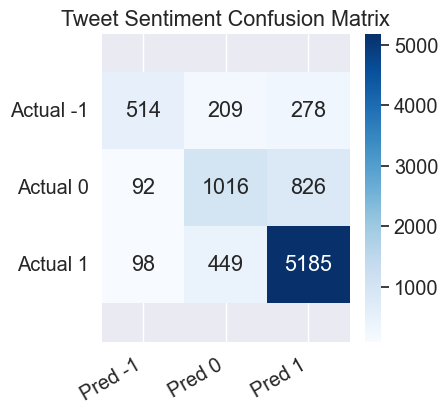

In [42]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram Logistic Regression



*** LogisticRegression ***
Accuracy:  0.746394369447329
Precision: 0.7365162059238626
Recall:    0.746394369447329
F1:        0.7189975438726154



[[ 298  213  467]
 [  43  790 1121]
 [  25  329 5381]]


/Users/nafis/code/python/climate change sentiment analysis/.venv311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


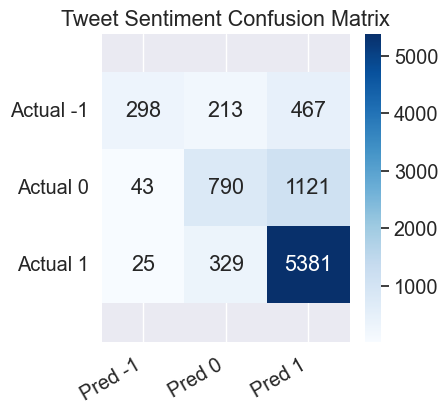

In [43]:
X_test, y_test, y_predicted, lrScoreDict2 = modelAndPredict(
    vectorizedTweets2, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Tri-gram Logistic Regression



*** LogisticRegression ***
Accuracy:  0.7222799123110649
Precision: 0.7179069563694689
Recall:    0.7222799123110649
F1:        0.6709167331322565



[[ 213  130  646]
 [  17  494 1419]
 [  22  173 5553]]


/Users/nafis/code/python/climate change sentiment analysis/.venv311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


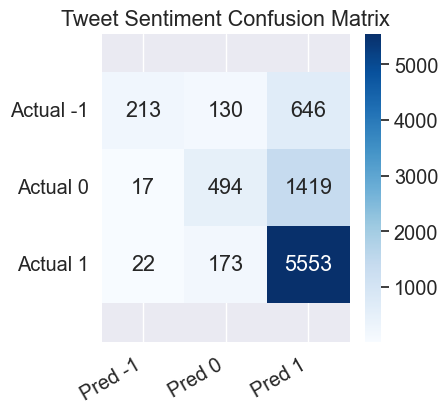

In [44]:
X_test, y_test, y_predicted, lrScoreDict3 = modelAndPredict(
    vectorizedTweets3, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram & Tri-Gram Logistic Regression

Note that I was not able to vectorize data ranging from 1 to 3-gram due to memory issue on my device.



*** LogisticRegression ***
Accuracy:  0.739586938963886
Precision: 0.7293058914491628
Recall:    0.739586938963886
F1:        0.7126392165375767



[[ 298  201  474]
 [  35  797 1152]
 [  38  357 5315]]


/Users/nafis/code/python/climate change sentiment analysis/.venv311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


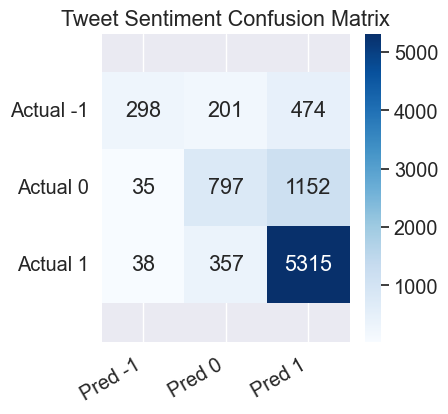

In [45]:
X_test, y_test, y_predicted, lrScoreDict23 = modelAndPredict(
    vectorizedTweets23, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### N-gram Comparisons

We have built different vectorized sentences using different ranges of N-grams (1, 2, 3, and 2 to 3). Each of them was fed to a logistic regression model and evaluated based on classification scores such as accuracy, precision, recall and F1. In this section, we will compare all the scores and see what N-gram has worked the best.


In [46]:
lsScoreDf = pd.DataFrame(lrScoreDict, index=["-"])
lsScoreDf2 = pd.DataFrame(lrScoreDict2, index=["Bi-gram"])
lsScoreDf3 = pd.DataFrame(lrScoreDict3, index=["Tri-gram"])
lsScoreDf23 = pd.DataFrame(lrScoreDict23, index=["Bi-gram and Tri-gram"])

lsScoreComparisonDf = pd.concat([lsScoreDf, lsScoreDf2, lsScoreDf3, lsScoreDf23])
lsScoreComparisonDf

,accuracy,recall,precision,f1
-,0.774778,0.774778,0.765019,0.765836
Bi-gram,0.746394,0.746394,0.736516,0.718998
Tri-gram,0.722280,0.722280,0.717907,0.670917
Bi-gram and Tri-gram,0.739587,0.739587,0.729306,0.712639


Logistic regression has worked the best when no N-gram was used to vectorize the sentences. Let's see if we can improve the model even further using different classification models.


## 2. Decision Tree


In [47]:
model = DecisionTreeClassifier(max_depth=20)


*** DecisionTreeClassifier ***
Accuracy:  0.706703588323526
Precision: 0.6905474423095429
Recall:    0.706703588323526
F1:        0.6482007057093728



[[ 255   70  691]
 [  60  363 1516]
 [  53  152 5507]]


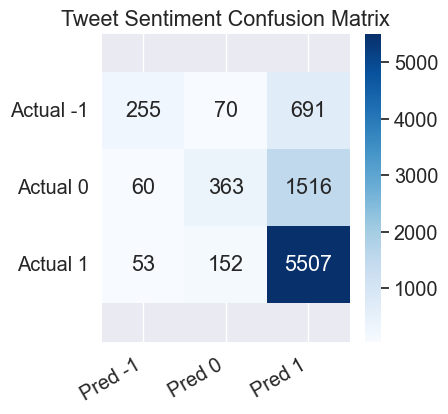

In [48]:
X_test, y_test, y_predicted, treeScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 3. Random Forest Classifier


In [49]:
model = RandomForestClassifier()


*** RandomForestClassifier ***
Accuracy:  0.755163262951425
Precision: 0.7501727989219877
Recall:    0.755163262951425
F1:        0.7312014183337615



Accuracy:  0.755163262951425
Precision: 0.7501727989219877
Recall:    0.755163262951425
F1:        0.7312014183337615



[[ 368  180  480]
 [  42  847 1079]
 [  22  319 5330]]
[[ 368  180  480]
 [  42  847 1079]
 [  22  319 5330]]


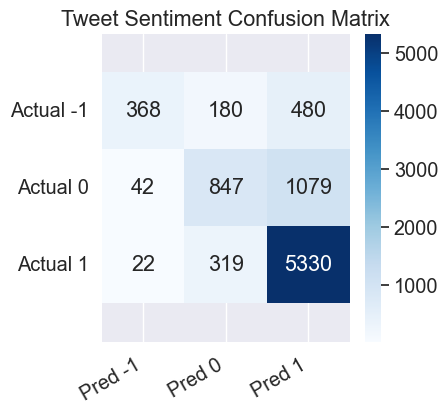

In [50]:
X_test, y_test, y_predicted, rfScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 4. Extra Trees Classifier


In [51]:
model = ExtraTreesClassifier()


*** ExtraTreesClassifier ***
Accuracy:  0.7559709241952233
Precision: 0.7474716559663029
Recall:    0.7559709241952233
F1:        0.7333759670027067



Accuracy:  0.7559709241952233
Precision: 0.7474716559663029
Recall:    0.7559709241952233
F1:        0.7333759670027067



[[ 361  205  453]
 [  44  853 1042]
 [  39  332 5338]]
[[ 361  205  453]
 [  44  853 1042]
 [  39  332 5338]]


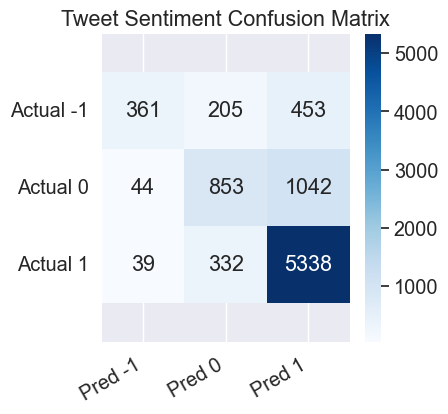

In [52]:
X_test, y_test, y_predicted, xtreeScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 5. K Neighbors Classifier


In [53]:
model = KNeighborsClassifier()


*** KNeighborsClassifier ***
Accuracy:  0.4691358024691358
Precision: 0.669060158803553
Recall:    0.4691358024691358
F1:        0.48780406295505163



Accuracy:  0.4691358024691358
Precision: 0.669060158803553
Recall:    0.4691358024691358
F1:        0.48780406295505163



[[ 184  670  130]
 [ 134 1530  259]
 [ 277 3131 2352]]
[[ 184  670  130]
 [ 134 1530  259]
 [ 277 3131 2352]]


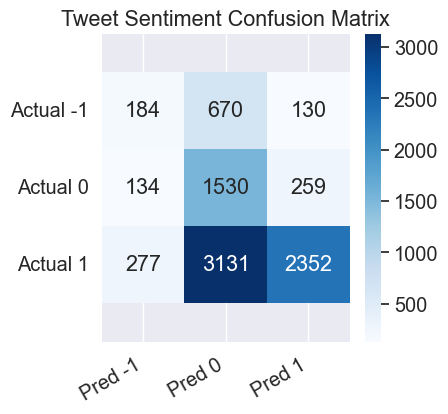

In [54]:
X_test, y_test, y_predicted, knnScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 6. Linear Support Vector Classifier (SVC)


In [55]:
model = SVC()


*** SVC ***
Accuracy:  0.7652013384100611
Precision: 0.7590090021287732
Recall:    0.7652013384100611
F1:        0.7394934044146909



Accuracy:  0.7652013384100611
Precision: 0.7590090021287732
Recall:    0.7652013384100611
F1:        0.7394934044146909



[[ 377  173  459]
 [  44  796 1094]
 [  30  235 5459]]
[[ 377  173  459]
 [  44  796 1094]
 [  30  235 5459]]


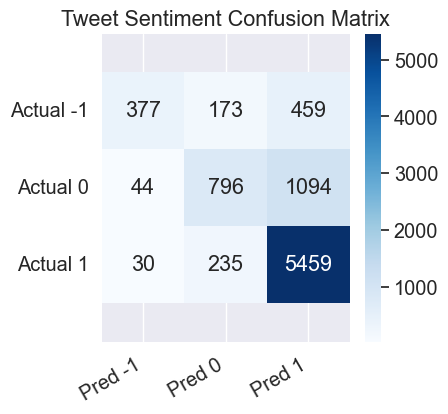

In [56]:
X_test, y_test, y_predicted, svcScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 7. Ridge Classifier


In [57]:
model = RidgeClassifier()


*** RidgeClassifier ***
Accuracy:  0.7765085958232376
Precision: 0.7656742200915302
Recall:    0.7765085958232376
F1:        0.7666977919263992



[[ 479  173  283]
 [ 103  994  845]
 [  77  456 5257]]


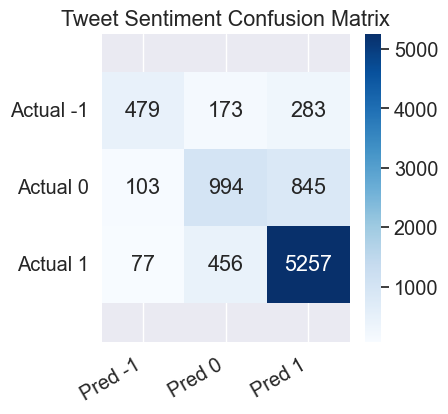

In [58]:
X_test, y_test, y_predicted, ridgeScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

# Model Comparisons


In [59]:
lrScoreDf = pd.DataFrame(lrScoreDict, index=["Logistic Regression"])
treeScoreDf = pd.DataFrame(treeScoreDict, index=["Decision Tree"])
rfScoreDf = pd.DataFrame(rfScoreDict, index=["Random Forest Classification"])
xtreeScoreDf = pd.DataFrame(xtreeScoreDict, index=["Extra Trees Classification"])
knnScoreDf = pd.DataFrame(knnScoreDict, index=["K Neighbors Classification"])
svcScoreDf = pd.DataFrame(
    svcScoreDict, index=["Linear Support Vector Classifier Classification"]
)
ridgeScoreDf = pd.DataFrame(ridgeScoreDict, index=["Ridge Classification"])

clsCompDf = pd.concat(
    [
        lrScoreDf,
        treeScoreDf,
        rfScoreDf,
        xtreeScoreDf,
        knnScoreDf,
        svcScoreDf,
        ridgeScoreDf,
    ]
)

clsCompDf.sort_values(by=["accuracy", "f1"], ascending=False)

,accuracy,recall,precision,f1
Ridge Classification,0.776509,0.776509,0.765674,0.766698
Logistic Regression,0.774778,0.774778,0.765019,0.765836
Linear Support Vector Classifier Classification,0.765201,0.765201,0.759009,0.739493
Extra Trees Classification,0.755971,0.755971,0.747472,0.733376
Random Forest Classification,0.755163,0.755163,0.750173,0.731201
Decision Tree,0.706704,0.706704,0.690547,0.648201
K Neighbors Classification,0.469136,0.469136,0.669060,0.487804


**Logistic Regression** seems to be performing the best because it has the highest accuracy, recall, precision and f1 among all models. **SVC** and **Ridge Classification** are also good runner-ups.


# Binary File Export

To reuse the built model to predict other tweets, we will be saving the model as a binary file.


In [60]:
def modelAndPredict(X, target, model):
    """
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    """

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.75)

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)

    # save model to a pickle file
    # create directory for models
    if not path.exists("./model"):
        makedirs("./model")
    pickle.dump(
        clfModel, open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "wb")
    )

    # load model
    loadedModel = pickle.load(
        open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "rb")
    )

    clsScoreDict = evaluateModel(loadedModel, X_test, y_test, modelType)

    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [61]:
model = LogisticRegression()


*** LogisticRegression ***
Accuracy:  0.7803161416868581
Precision: 0.7711493817619717
Recall:    0.7803161416868581
F1:        0.7700507641641279



[[ 515  188  281]
 [  68 1027  876]
 [  84  407 5221]]


/Users/nafis/code/python/climate change sentiment analysis/.venv311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


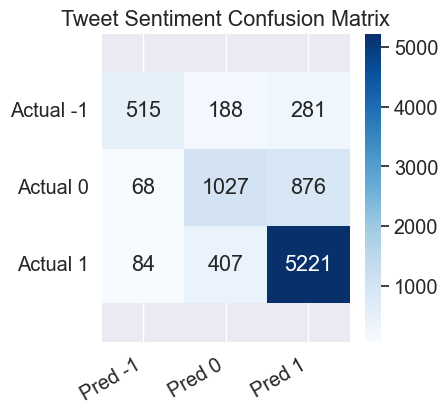

In [62]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

We also need a reference to vectors for each word found in the dataset. The word dictionary will be exported as a JSON file. Each unique word in the dataset is associated with its vector value.


In [63]:
with open("wordDictionary.json", "w") as fp:
    json.dump(vectorDictionary, fp)